In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time

from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB

from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import LabelEncoder
from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing
from hpsklearn import svc_rbf
from hpsklearn import svc
from hpsklearn import standard_scaler
from hyperopt import tpe

import os

import eli5

plt.style.use('ggplot')

WARN: OMP_NUM_THREADS=7 =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


# Sapient freesufer 

Rename freesurfer outputs from SAPIENT to actual subject id

In [2]:
xnat_allsub="/Users/TienTong/Documents/dcm2bids/xnat_allsubjects.csv"
df = pd.read_csv(xnat_allsub, header=None)
df = df.iloc[:-6,:]
df['freesurfer'] = os.listdir("/Volumes/BACHI-LAB/MRI_DATA/FreeSurfer6_HAs_key/")
df.iloc[:, [0,1,3,4]]

,0,1,3,freesurfer
0,0,TMII_XNAT_S12035,sub-P18001,17-1290_TMII_XNAT_S12035_FreeSurfer6_HAs-key
1,1,TMII_XNAT_S12055,sub-P18003,17-1290_TMII_XNAT_S12055_FreeSurfer6_HAs-key
2,2,TMII_XNAT_S12081,sub-P18002,17-1290_TMII_XNAT_S12081_FreeSurfer6_HAs-key
3,3,TMII_XNAT_S12107,sub-P18004,17-1290_TMII_XNAT_S12107_FreeSurfer6_HAs-key
4,4,TMII_XNAT_S12228,sub-P18006,17-1290_TMII_XNAT_S12228_FreeSurfer6_HAs-key
...,...,...,...,...
66,66,XNAT_S01094,sub-P21009,17-1290_XNAT_S01094_FreeSurfer6_HAs-key
67,67,XNAT_S01292,sub-P21012,17-1290_XNAT_S01292_FreeSurfer6_HAs-key
68,68,XNAT_S01326,sub-P21011,17-1290_XNAT_S01326_FreeSurfer6_HAs-key
69,69,XNAT_S01378,sub-P21013,17-1290_XNAT_S01378_FreeSurfer6_HAs-key


In [ ]:
# RENAME FILE DOWNLOADED FROM SAPIENT

os.chdir("/Volumes/BACHI-LAB/MRI_DATA/FreeSurfer6_HAs_key_rename")
for row in range(df.shape[0]): 
    try:
        os.rename(df.iloc[row, 4], df.iloc[row, 3])
    except:
        pass

# AGGREGATE FREESURFER ASEG AND APARC VOLUME TO CREATE DATAFRAMES WITH ALL SUBJECTS

In [ ]:
%%bash

# COMMENT OUT BECAUSE DON'T NEED THIS ANYMORE
# ORGANIZE INDIVIDUAL SUBJECT ASEG

# fs_out_dir=/Volumes/BACHI-LAB/MRI_DATA/FreeSurfer6_HAs_key_rename
# files_array=(`ls $fs_out_dir/*/subject/stats/aseg.stats`)

# for i in ${!files_array[@]} ; do
#     sub_id_full=`echo ${files_array[$i]} | cut -d '/' -f 6`
#     sub_id_short=`echo $sub_id_full | cut -d '-' -f 2`
   
#     tpm_1=$fs_out_dir/$sub_id_full/tpm_1.tsv
#     tpm_2=$fs_out_dir/$sub_id_full/tpm_2.tsv
#     out=$fs_out_dir/$sub_id_full/aseg_organized.tsv

#     awk 'FNR > 80 { print $5 }' ${files_array[$i]} | tr '\n' '\t'  > $tpm_1 # column 5 = structure name
#     echo ""  >> $tpm_1 # add new line
#     awk 'FNR > 80 { print $4 }' ${files_array[$i]} | tr '\n' '\t' >> $tpm_1 # column 4 = volume

#     sed '1s/^/id \t/' $tpm_1 > $tpm_2 # add id variable
#     sed "2s/^/$sub_id_short \t/" $tpm_2 > $out # add subject id
    
#     rm $tpm_1 $tpm_2
# done

# # CONCATNATE ALL ASEG FILES

# for f in $fs_out_dir/*/aseg_organized.tsv ; do (cat "${f}"; echo) >> $fs_out_dir/tmp.txt ; done

# # The n flag passed to cat appends line numbers to left of every line, plus space, then the first sort says sort by unique and but only after the first word, the second sort command says use the line numbers we stored in step 1 to resort by the original ordering, finally cut off the first word.
# cat -n $fs_out_dir/tmp.txt | sort -uk2 | sort -nk1 | cut -f2- > $fs_out_dir/aseg_allsub.txt
# rm $fs_out_dir/tmp.txt

In [ ]:
%%bash

fs_out_dir=/Volumes/BACHI-LAB/MRI_DATA/FreeSurfer6_HAs_key_rename

# /Users/TienTong/freesurfer/7.2.0/SetUpFreeSurfer.sh
# REORGANIZE THE FILES BECAUSE OUTPUTS DOWNLOADED FROM SAPIENT WERE ORGANIZED A LITTLE DIFFERENT THAN FREESURFER CONVENTION
# files_array=(`ls $fs_out_dir/*/subject/stats/aseg.stats`)
# for i in ${!files_array[@]} ; do
#     sub_id_full=`echo ${files_array[$i]} | cut -d '/' -f 6`
#     mv $fs_out_dir/$sub_id_full/subject/* $fs_out_dir/$sub_id_full
#     rm -rf $fs_out_dir/$sub_id_full/subject
# done

ls -d $fs_out_dir/sub* > $fs_out_dir/allsub_list.txt

# AGGREGATE FREESURFER OUTPUT TO CREATE DATAFRAMES WITH ALL SUBJECTS
asegstats2table \
  --inputs $fs_out_dir/*/stats/aseg.stats \
  --tablefile $fs_out_dir/aseg_allsub.txt

aparcstats2table \
  --subjectsfile $fs_out_dir/allsub_list.txt \
  --hemi rh \
  --meas volume \
  --tablefile $fs_out_dir/aparc_allsub_r.txt

aparcstats2table \
  --subjectsfile $fs_out_dir/allsub_list.txt \
  --hemi lh \
  --meas volume \
  --tablefile $fs_out_dir/aparc_allsub_l.txt

# Finalize FreeSurfer dataframe input to ML

   * Combine aseg and aparc
   * exclude composite volume variables (e.g., 'lhCortexVol', 'rhCortexVol', 'CortexVol'), and variables that are mostly NA across all subjects (5th ventricle)

In [3]:
fs_out_dir = '/Volumes/BACHI-LAB/MRI_DATA/FreeSurfer6_HAs_key_rename'

aparc_r = pd.read_csv(fs_out_dir + '/aparc_allsub_r.txt', sep='\t')
aparc_l = pd.read_csv(fs_out_dir + '/aparc_allsub_l.txt', sep='\t')
aparc = aparc_r.merge(aparc_l, how='outer')

aseg = pd.read_csv(fs_out_dir + '/aseg_allsub.txt', sep='\t')
aseg.rename(columns={"EstimatedTotalIntraCranialVol": "eTIV"}, inplace=True)

freesurfer = aseg.merge(aparc, how='outer')
group = pd.read_csv('/Users/TienTong/Documents/k23_explore/matrix_ctq.csv', 
                    usecols=['record_id', 'drug_group', 'trauma_group', 'ctq_total_score_2'])
freesurfer = group.merge(freesurfer, left_index=True, right_index=True)
freesurfer.drop(columns=['Measure:volume', '5th-Ventricle', 'Left-WM-hypointensities', 'Right-WM-hypointensities', 
                         'non-WM-hypointensities', 'Left-non-WM-hypointensities', 'Right-non-WM-hypointensities', 
                         'rh.aparc.volume', 'lh.aparc.volume',
                         'BrainSegVol', 'BrainSegVolNotVent', 'BrainSegVolNotVentSurf',
                         'lhCortexVol', 'rhCortexVol', 'CortexVol',
                         'SubCortGrayVol', 'TotalGrayVol',
                         'SupraTentorialVol', 'SupraTentorialVolNotVent', 'SupraTentorialVolNotVentVox',
                         'MaskVol', 'BrainSegVol-to-eTIV', 'MaskVol-to-eTIV', 'SurfaceHoles',
                         'CSF', 'Right-Lateral-Ventricle', 'Left-Lateral-Ventricle',
                         'CerebralWhiteMatterVol'], inplace=True)

freesurfer.loc[freesurfer['record_id']=='P21002_P20013', 'record_id'] = 'P21002'

freesurfer.to_csv('/Volumes/BACHI-LAB/MRI_DATA/FreeSurfer6_HAs_key_rename/freesurfer.csv', index=False)


# Finalize Immune dataframe input to ML

   * Filter to keep K23 data only
   * Keep MFI columns, id, drug group (GroupName)

In [4]:
immune = pd.read_spss('/Volumes/BACHI-LAB/Data_Warehouse/PKB_K23Interim_Brain_Behavior_BloodData_Combined_N38andN63_5.2.21.sav')

immune = immune[immune['Sample'].str.contains("KBA_K23")]
immune.dropna(subset=['age'], inplace = True)

immune['record_id'] = 0
for i in range(immune.shape[0]):
    immune.loc[i, 'record_id'] = str(immune.loc[i, 'Sample'].split('_')[2])
    if 'P' not in str(immune['record_id'][i]):
        immune.loc[i, 'record_id'] = 'P' + str(immune.loc[i, 'record_id'])
    
mfi_cols = [col for col in immune.columns if '_MFI' in col]

mfi_cols.extend(['record_id', 'GroupName', 'age', 'Sex', 'sex_recoded'])
immune = immune.loc[:, mfi_cols]
immune.dropna(inplace=True)
immune.to_csv('/Volumes/BACHI-LAB/Data_Warehouse/immune.csv', index=False)

# Load data for ML

   * For freesurfer dataframe: normalized all volumetric data by eTIV
   * 108 volumetric variables, no composite --- keep only 86 gray matter volumes
   * 69 participants

In [5]:
freesurfer = pd.read_csv('/Volumes/BACHI-LAB/MRI_DATA/FreeSurfer6_HAs_key_rename/freesurfer.csv')
# freesurfer = pd.read_csv('/Users/tientong/Documents/Bachi/r01/freesurfer.csv')
freesurfer.iloc[:,4:] = freesurfer.iloc[:,4:].div(freesurfer.eTIV, axis=0)
freesurfer.drop(columns=['eTIV'], inplace=True)

freesurfer

freesurfer.columns.str.contains("Vent")

searchfor = ['Vent', 'vent', 'white', 'White', 'vessel', 'choroid-plexus', 'WM', 'Optic-Chiasm', 'CC_',
            'SurfaceHoles']
freesurfer_gm = freesurfer.loc[:, ~freesurfer.columns.str.contains('|'.join(searchfor))]
freesurfer_gm[['Left-VentralDC', 'Right-VentralDC']] = freesurfer[['Left-VentralDC', 'Right-VentralDC']]

freesurfer_gm.info(verbose=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 91 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   record_id                           69 non-null     object 
 1   ctq_total_score_2                   69 non-null     int64  
 2   drug_group                          69 non-null     object 
 3   trauma_group                        69 non-null     object 
 4   Left-Cerebellum-Cortex              69 non-null     float64
 5   Left-Thalamus-Proper                69 non-null     float64
 6   Left-Caudate                        69 non-null     float64
 7   Left-Putamen                        69 non-null     float64
 8   Left-Pallidum                       69 non-null     float64
 9   Brain-Stem                          69 non-null     float64
 10  Left-Hippocampus                    69 non-null     float64
 11  Left-Amygdala                       69 non-null

/Users/TienTong/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


# Immune

   * 40 immune variables, no composite
   * 61 participants


In [6]:
immune = pd.read_csv('/Volumes/BACHI-LAB/Data_Warehouse/immune.csv')
# immune = pd.read_csv('/Users/tientong/Documents/Bachi/r01/immune.csv')

immune.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 46 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EGF_MFI          61 non-null     float64
 1   FGF2_MFI         61 non-null     float64
 2   Eotaxin_MFI      61 non-null     float64
 3   TGFa_MFI         61 non-null     float64
 4   GCSF_MFI         61 non-null     float64
 5   Flt3L_MFI        61 non-null     float64
 6   GMCSF_MFI        61 non-null     float64
 7   Fractalkine_MFI  61 non-null     float64
 8   IFNa2_MFI        61 non-null     float64
 9   IFNg_MFI         61 non-null     float64
 10  GRO_MFI          61 non-null     float64
 11  IL10_MFI         61 non-null     float64
 12  MCP3_MFI         61 non-null     float64
 13  IL12P40_MFI      61 non-null     float64
 14  MDC_MFI          61 non-null     float64
 15  IL12P70_MFI      61 non-null     float64
 16  PDGFAA_MFI       61 non-null     float64
 17  IL13_MFI         6

# Combine volumetric and immune data

   * For freesurfer dataframe: normalized all volumetric data by eTIV
   * 40 immune variables + 86 volumetric variables, no composite = 126
   * 61 participants, exclude 4, left with 57 -- reassign trauma group based on new median CTQ (35)


In [7]:
mergedf = freesurfer_gm.merge(immune, on='record_id')

# EXCLUDE BAD T1
exclude = ['P19053', 'P19016', 'P19025', 'P18017']
mergedf = mergedf.loc[~mergedf['record_id'].isin(exclude), :]

# reassign trauma group
print("Median CTQ:", np.median(mergedf.ctq_total_score_2))
mergedf.loc[mergedf.ctq_total_score_2 < np.median(mergedf.ctq_total_score_2), 'trauma_group'] = 'Low Trauma'
mergedf.loc[mergedf.ctq_total_score_2 >= np.median(mergedf.ctq_total_score_2), 'trauma_group'] = 'High Trauma'


mergedf = mergedf.drop(['GroupName'], axis=1)
mergedf['drug_trauma'] = mergedf['drug_group'] + ' ' + mergedf['trauma_group']
mergedf['drug_trauma'] = mergedf['drug_trauma'].astype('category')
mergedf['drug_trauma_fac'] = mergedf['drug_trauma'].factorize()[0]

mergedf.shape


Median CTQ: 35.0


(57, 137)

In [8]:
mergedf['drug_trauma'].value_counts()
print(mergedf['drug_group'].value_counts())
print(mergedf[['drug_group', 'Sex']].value_counts())

mergedf.groupby('drug_group').age.describe()



CUD    29
HC     28
Name: drug_group, dtype: int64
drug_group  Sex   
CUD         male      22
HC          male      17
            female    11
CUD         female     7
dtype: int64


,count,mean,std,min,25%,50%,75%,max
drug_group,,,,,,,,
CUD,29.0,48.700686,9.274075,29.791166,41.194549,52.915529,54.511843,60.077893
HC,28.0,45.749367,9.944280,26.634245,38.937173,48.404827,51.237819,59.492095


# Drug x Trauma

small sample size, will be even small after train_test_split, also poor performance, not focus on this classification for now

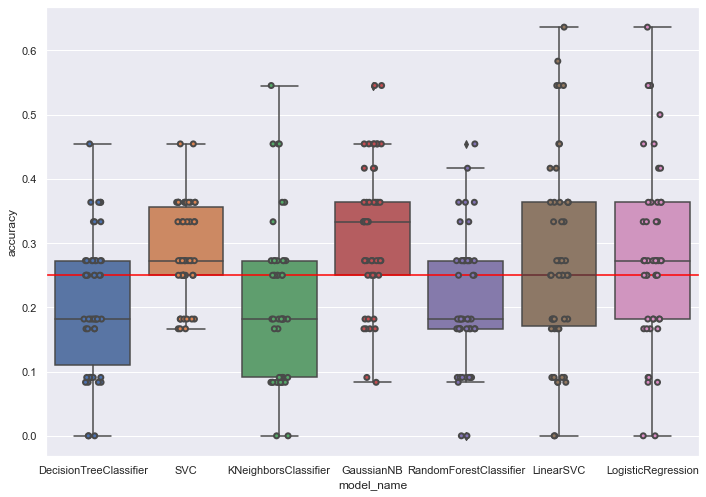

In [9]:
X, y = mergedf.iloc[:, 4:-5], mergedf['drug_trauma_fac']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

models = [
    DecisionTreeClassifier(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
    LinearSVC(),
    LogisticRegression(),
]

n_splits=5
n_repeats=10
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
cv_df = pd.DataFrame(index=range(n_splits * n_repeats * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    pipeline = Pipeline([
                ('ss', StandardScaler()),
                ('clf', model)])
    accuracies = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
graph = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=5, jitter=True, edgecolor="gray", linewidth=2)
graph.axhline(0.25, color='red')
plt.show()



#  PREDICTING TRAUMA GROUP WITHOUT PCA

VERY POOR PERFORMANCE when X = brain + immune, focus on drug group for now

With train_test_split(test_size=0.2):
   * Train High Trauma:  23
   * Train Low Trauma:  22
   * Test High Trauma:  6
   * Test Low Trauma:  6

In [10]:
X_brain = mergedf.iloc[:, 4:91]
X_immune = mergedf.iloc[:, 91:-5]
X_combine = mergedf.iloc[:, 4:-5]

for X in [X_brain, X_immune, X_combine]:

    y = pd.get_dummies(mergedf['trauma_group']).iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
#     print('Train High Trauma: ', sum(y_train==1))
#     print('Train Low Trauma: ', sum(y_train==0))
#     print('Test High Trauma: ', sum(y_test==1))
#     print('Test Low Trauma: ', sum(y_test==0))

    accuracy_nopca=[]
    auc_nopca=[]
    precision_nopca=[]
    recall_nopca=[]

    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    for kernel in kernels:
        ss = StandardScaler()
        svc = SVC(kernel=kernel)

        model_nopca = make_pipeline(ss, svc)
        model_nopca.fit(X_train, y_train)
        y_pred_nopca = model_nopca.predict(X_test)

    #     print(classification_report(y_test, y_pred_nopca))
        accuracy_nopca.append(accuracy_score(y_test, y_pred_nopca))
        auc_nopca.append(roc_auc_score(y_test, y_pred_nopca))
        precision_nopca.append(precision_score(y_test, y_pred_nopca))
        recall_nopca.append(recall_score(y_test, y_pred_nopca))

    accuracy_nopca_df = pd.DataFrame(zip(accuracy_nopca, auc_nopca, precision_nopca, recall_nopca), index=kernels)
    accuracy_nopca_df.columns = ['Accuracy', 'AUC', 'Precision', 'Recall']
#     accuracy_nopca_df.sort_values(by = 'Accuracy', ascending = False, inplace=True)

    print("\nMODEL PERFORMANCE")
    print(accuracy_nopca_df)



MODEL PERFORMANCE
         Accuracy       AUC  Precision    Recall
linear   0.583333  0.583333   0.600000  0.500000
poly     0.500000  0.500000   0.500000  1.000000
rbf      0.250000  0.250000   0.285714  0.333333
sigmoid  0.416667  0.416667   0.428571  0.500000

MODEL PERFORMANCE
         Accuracy       AUC  Precision    Recall
linear   0.416667  0.416667   0.400000  0.333333
poly     0.583333  0.583333   0.545455  1.000000
rbf      0.500000  0.500000   0.500000  0.500000
sigmoid  0.250000  0.250000   0.000000  0.000000

MODEL PERFORMANCE
         Accuracy       AUC  Precision    Recall
linear   0.416667  0.416667   0.428571  0.500000
poly     0.500000  0.500000   0.500000  0.833333
rbf      0.250000  0.250000   0.000000  0.000000
sigmoid  0.416667  0.416667   0.333333  0.166667


#  PREDICTING DRUG GROUP WITHOUT PCA 

With train_test_split(test_size=0.2):
   * Train CUD:  23
   * Train HC:  22
   * Test CUD:  6
   * Test HC:  6
   
   
POOR PERFORMANCE, HAVE TO TUNE HYPERPARAMETERS

In [14]:
# X, y = mergedf.iloc[:, 4:-5], pd.get_dummies(mergedf['drug_group']).iloc[:,0]

X_brain = mergedf.iloc[:, 4:91]
X_immune = mergedf.iloc[:, 91:-5]
X_combine = mergedf.iloc[:, 4:-5]

for X in [X_brain, X_immune, X_combine]:

    y = pd.get_dummies(mergedf['drug_group']).iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
#     print('Train CUD: ', sum(y_train==1))
#     print('Train HC: ', sum(y_train==0))
#     print('Test CUD: ', sum(y_test==1))
#     print('Test HC: ', sum(y_test==0))

    accuracy_nopca=[]
    auc_nopca=[]
    precision_nopca=[]
    recall_nopca=[]

    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    for kernel in kernels:
        ss = StandardScaler()
        svc = SVC(kernel=kernel)

        model_nopca = make_pipeline(ss, svc)
        model_nopca.fit(X_train, y_train)
        y_pred_nopca = model_nopca.predict(X_test)

    #     print(classification_report(y_test, y_pred_nopca))
        accuracy_nopca.append(accuracy_score(y_test, y_pred_nopca))
        auc_nopca.append(roc_auc_score(y_test, y_pred_nopca))
        precision_nopca.append(precision_score(y_test, y_pred_nopca))
        recall_nopca.append(recall_score(y_test, y_pred_nopca))

    eval_nopca_df = pd.DataFrame(zip(accuracy_nopca, auc_nopca, precision_nopca, recall_nopca), index=kernels)
    eval_nopca_df.columns = ['Accuracy', 'AUC', 'Precision', 'Recall']
#     accuracy_nopca_df.sort_values(by = 'Accuracy', ascending = False, inplace=True)

    print("\nMODEL PERFORMANCE \n")
    print(eval_nopca_df)


MODEL PERFORMANCE 

         Accuracy       AUC  Precision    Recall
linear   0.666667  0.666667   0.625000  0.833333
poly     0.500000  0.500000   0.500000  1.000000
rbf      0.583333  0.583333   0.545455  1.000000
sigmoid  0.583333  0.583333   0.555556  0.833333

MODEL PERFORMANCE 

         Accuracy       AUC  Precision    Recall
linear   0.500000  0.500000   0.500000  0.666667
poly     0.583333  0.583333   0.545455  1.000000
rbf      0.666667  0.666667   0.600000  1.000000
sigmoid  0.750000  0.750000   0.666667  1.000000

MODEL PERFORMANCE 

         Accuracy       AUC  Precision    Recall
linear   0.416667  0.416667   0.400000  0.333333
poly     0.583333  0.583333   0.545455  1.000000
rbf      0.666667  0.666667   0.600000  1.000000
sigmoid  0.666667  0.666667   0.625000  0.833333


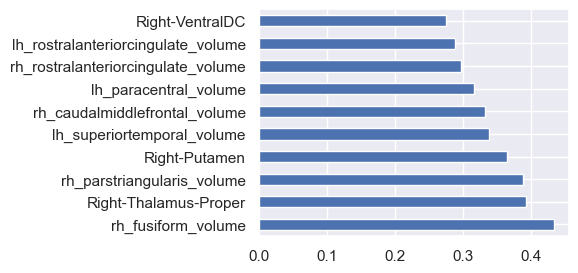

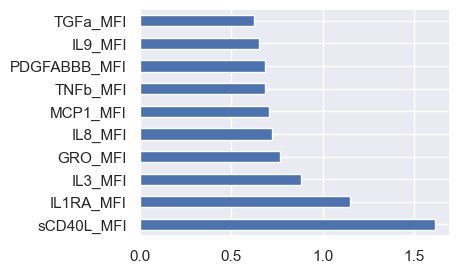

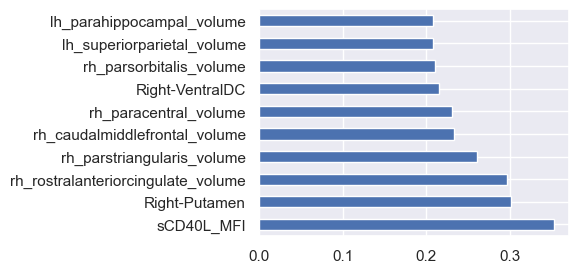

In [15]:
# X, y = mergedf.iloc[:, 4:-5], pd.get_dummies(mergedf['drug_group']).iloc[:,0]

X_brain = mergedf.iloc[:, 4:91]
X_immune = mergedf.iloc[:, 91:-5]
X_combine = mergedf.iloc[:, 4:-5]

for X in [X_brain, X_immune, X_combine]:

    y = pd.get_dummies(mergedf['drug_group']).iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
#     print('Train CUD: ', sum(y_train==1))
#     print('Train HC: ', sum(y_train==0))
#     print('Test CUD: ', sum(y_test==1))
#     print('Test HC: ', sum(y_test==0))

    accuracy_nopca=[]
    auc_nopca=[]
    precision_nopca=[]
    recall_nopca=[]

    kernels = ['linear']
    for kernel in kernels:
        ss = StandardScaler()
        svc = SVC(kernel=kernel)

        model_nopca = make_pipeline(ss, svc)
        model_nopca.fit(X_train, y_train)

        features_names = list(X.columns)
        figure(figsize=(4, 3), dpi=100)
        pd.Series(abs(model_nopca.named_steps['svc'].coef_[0]), index=X.columns).nlargest(10).plot(kind='barh')
        plt.show()
        
        

# Tuning hyperparameters

In [ ]:
# np.arange(0.0001,100,5)

In [16]:
X, y = mergedf.iloc[:, 4:-5], pd.get_dummies(mergedf['drug_group']).iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

ss = StandardScaler()
# pca = PCA(n_components=0.90, whiten=True, random_state=42)
svc = SVC()
model = make_pipeline(ss, svc)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats= 10, random_state=1)

param_grid = {'svc__C': [0.005],
              'svc__kernel': ['linear']}

grid = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy')
grid.fit(X_train, y_train)
print(grid.best_params_)

model = grid.best_estimator_
yfit = model.predict(X_test)

print(classification_report(y_test, yfit))


{'svc__C': 0.005, 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.67      1.00      0.80         6

    accuracy                           0.75        12
   macro avg       0.83      0.75      0.73        12
weighted avg       0.83      0.75      0.73        12



In [ ]:
# X, y = mergedf.iloc[:, 4:-5], pd.get_dummies(mergedf['drug_group']).iloc[:,0]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats= 10, random_state=1)

# ss = StandardScaler()
# # pca = PCA(n_components=0.90, whiten=True, random_state=42)
# svc = SVC(kernel='rbf')
# model = make_pipeline(ss, svc)


# param_grid = {'svc__C': [0.0001, 0.0005, 0.001, 0.005, 1, 5, 10, 50, 100],
#               'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
# grid = GridSearchCV(model, param_grid, cv=cv, refit = True)

# %time grid.fit(X_train, y_train)
# print(grid.best_params_)

# model = grid.best_estimator_
# yfit = model.predict(X_test)

# print(classification_report(y_test, yfit))


# cross validation using the tuned C

In [36]:
# WITHOUT PCA

X_brain = mergedf.iloc[:, 4:91]
X_immune = mergedf.iloc[:, 91:-5]
X_combine = mergedf.iloc[:, 4:-5]

for X in [X_brain, X_immune, X_combine]:
    
    y = pd.get_dummies(mergedf['drug_group']).iloc[:,0]
    scoring = ['accuracy', 'roc_auc', 'precision', 'recall']

    ss = StandardScaler()
    svc = SVC(kernel='linear', C=0.005)
    model = make_pipeline(ss, svc)

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats= 10, random_state=10)
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

    print("\nCROSS VALIDATION SCORE FOR SVC linear")
    print("accuracy mean", np.mean(cv_results['test_accuracy']), "| accuracy std", np.std(cv_results['test_accuracy']))
    print("auc mean", np.mean(cv_results['test_roc_auc']), "| auc std", np.std(cv_results['test_roc_auc']))
    print("precision mean", np.mean(cv_results['test_precision']), "| precision std", np.std(cv_results['test_precision']))
    print("recall mean", np.mean(cv_results['test_recall']), "| recall std", np.std(cv_results['test_recall']))



CROSS VALIDATION SCORE FOR SVC linear
accuracy mean 0.5557575757575758 | accuracy std 0.10593889119913998
auc mean 0.5472222222222222 | auc std 0.17414429237819204
precision mean 0.5450295815295816 | precision std 0.08421222044174739
recall mean 0.8926666666666666 | recall std 0.13288089905375164

CROSS VALIDATION SCORE FOR SVC linear
accuracy mean 0.5312121212121212 | accuracy std 0.07089937773411976
auc mean 0.5933333333333334 | auc std 0.1584765434214629
precision mean 0.5230194805194806 | precision std 0.04940292321591516
recall mean 0.9613333333333333 | recall std 0.08037688998987484

CROSS VALIDATION SCORE FOR SVC linear
accuracy mean 0.636969696969697 | accuracy std 0.1087414436223154
auc mean 0.5892222222222222 | auc std 0.17203721245456116
precision mean 0.5993391053391054 | precision std 0.0923589845236652
recall mean 0.9306666666666668 | recall std 0.09161271139361003


In [18]:
# WITH PCA

X_brain = mergedf.iloc[:, 4:91]
X_immune = mergedf.iloc[:, 91:-5]
X_combine = mergedf.iloc[:, 4:-5]

for X in [X_brain, X_immune, X_combine]:
    
    y = pd.get_dummies(mergedf['drug_group']).iloc[:,0]
    scoring = ['accuracy', 'roc_auc', 'precision', 'recall']

    ss = StandardScaler()
    pca = PCA(n_components=0.7, whiten=True, random_state=42)
#     svc = SVC(kernel='linear', C=0.005)
    svc = SVC(kernel='linear')
    model = make_pipeline(ss, pca, svc)

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats= 10, random_state=10)
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

    print("\nCROSS VALIDATION SCORE FOR SVC linear")
    print("accuracy mean", np.mean(cv_results['test_accuracy']), "| accuracy std", np.std(cv_results['test_accuracy']))
    print("auc mean", np.mean(cv_results['test_roc_auc']), "| auc std", np.std(cv_results['test_roc_auc']))
    print("precision mean", np.mean(cv_results['test_precision']), "| precision std", np.std(cv_results['test_precision']))
    print("recall mean", np.mean(cv_results['test_recall']), "| recall std", np.std(cv_results['test_recall']))



CROSS VALIDATION SCORE FOR SVC linear
accuracy mean 0.585 | accuracy std 0.13242016844159732
auc mean 0.6266666666666666 | auc std 0.17860916708808997
precision mean 0.5874365079365079 | precision std 0.15951171892110952
recall mean 0.652 | recall std 0.22212709074861728

CROSS VALIDATION SCORE FOR SVC linear
accuracy mean 0.5434848484848486 | accuracy std 0.10287209332438178
auc mean 0.5963333333333334 | auc std 0.15840879293464852
precision mean 0.5372056277056277 | precision std 0.09484140997257878
recall mean 0.8786666666666667 | recall std 0.17071874205513843

CROSS VALIDATION SCORE FOR SVC linear
accuracy mean 0.5993939393939394 | accuracy std 0.13898688920866178
auc mean 0.6073333333333334 | auc std 0.1727998914037153
precision mean 0.5938015873015873 | precision std 0.16492357365577637
recall mean 0.6866666666666668 | recall std 0.23607908279501033


# Feature importance: linear SVC, no PCA

In [19]:
# X, y = mergedf.iloc[:, 4:-5], pd.get_dummies(mergedf['drug_group']).iloc[:,0]

X_brain = mergedf.iloc[:, 4:91]
X_immune = mergedf.iloc[:, 91:-5]
X_combine = mergedf.iloc[:, 4:-5]
y = pd.get_dummies(mergedf['drug_group']).iloc[:,0]

feature_importance_brain = pd.Series(dtype='float64')
feature_importance_immune = pd.Series(dtype='float64')
feature_importance_combine = pd.Series(dtype='float64')

ss = StandardScaler()
svc = SVC(kernel='linear', C=0.005)
model = make_pipeline(ss, svc)

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats= 10, random_state=10)

for train_index, test_index in rskf.split(X_brain, y):
    X_train, X_test, y_train, y_test = X_brain.iloc[train_index], X_brain.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    features_names = list(X_brain.columns)
    feature_importance_brain = feature_importance_brain.append(pd.Series(abs(model.named_steps['svc'].coef_[0]), index=X_brain.columns))

for train_index, test_index in rskf.split(X_immune, y):
    X_train, X_test, y_train, y_test = X_immune.iloc[train_index], X_immune.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    features_names = list(X_immune.columns)
    feature_importance_immune = feature_importance_immune.append(pd.Series(abs(model.named_steps['svc'].coef_[0]), index=X_immune.columns))

for train_index, test_index in rskf.split(X_combine, y):
    X_train, X_test, y_train, y_test = X_combine.iloc[train_index], X_combine.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    features_names = list(X_combine.columns)
    feature_importance_combine = feature_importance_combine.append(pd.Series(abs(model.named_steps['svc'].coef_[0]), index=X_combine.columns))


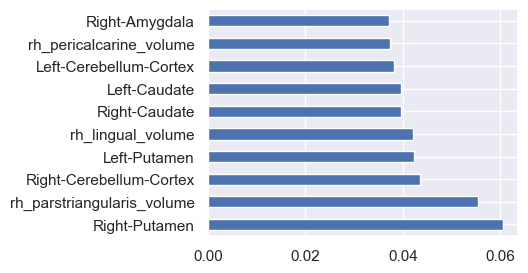

In [20]:
#         figure(figsize=(4, 3), dpi=100)
#         pd.Series(abs(model_nopca.named_steps['svc'].coef_[0]), index=X.columns).nlargest(10).plot(kind='barh')
#         plt.show()


feature_importance_brain_avg = pd.Series(dtype='float64')

for var in X_brain.columns:
    feature_importance_brain_avg = feature_importance_brain_avg.append(pd.Series(feature_importance_brain.loc[var].mean(), index=[var]))
    
figure(figsize=(4, 3), dpi=100)        
feature_importance_brain_avg.nlargest(10).plot(kind='barh')
plt.show()


In [21]:
feature_importance_brain_avg.nlargest(10)

Right-Putamen                 0.060690
rh_parstriangularis_volume    0.055418
Right-Cerebellum-Cortex       0.043508
Left-Putamen                  0.042211
rh_lingual_volume             0.042116
Right-Caudate                 0.039730
Left-Caudate                  0.039658
Left-Cerebellum-Cortex        0.038278
rh_pericalcarine_volume       0.037391
Right-Amygdala                0.037110
dtype: float64

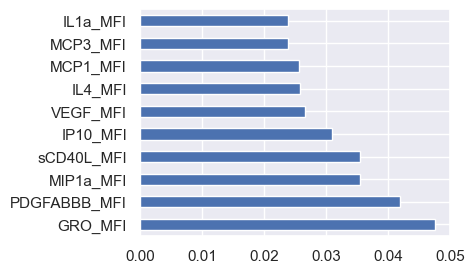

In [22]:
feature_importance_immune_avg = pd.Series(dtype='float64')

for var in X_immune.columns:
    feature_importance_immune_avg = feature_importance_immune_avg.append(pd.Series(feature_importance_immune.loc[var].mean(), index=[var]))
    
figure(figsize=(4, 3), dpi=100)        
feature_importance_immune_avg.nlargest(10).plot(kind='barh')
plt.show()

In [23]:
feature_importance_immune_avg.nlargest(10)

GRO_MFI         0.047661
PDGFABBB_MFI    0.041962
MIP1a_MFI       0.035467
sCD40L_MFI      0.035466
IP10_MFI        0.030934
VEGF_MFI        0.026625
IL4_MFI         0.025886
MCP1_MFI        0.025639
MCP3_MFI        0.023926
IL1a_MFI        0.023846
dtype: float64

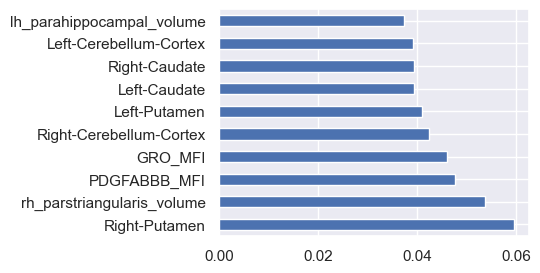

In [24]:
feature_importance_combine_avg = pd.Series(dtype='float64')

for var in X_combine.columns:
    feature_importance_combine_avg = feature_importance_combine_avg.append(pd.Series(feature_importance_combine.loc[var].mean(), index=[var]))
    
figure(figsize=(4, 3), dpi=100)        
feature_importance_combine_avg.nlargest(10).plot(kind='barh')
plt.show()

In [25]:
feature_importance_combine_avg.nlargest(10)

Right-Putamen                 0.059695
rh_parstriangularis_volume    0.053726
PDGFABBB_MFI                  0.047793
GRO_MFI                       0.046043
Right-Cerebellum-Cortex       0.042545
Left-Putamen                  0.040981
Left-Caudate                  0.039342
Right-Caudate                 0.039315
Left-Cerebellum-Cortex        0.039291
lh_parahippocampal_volume     0.037432
dtype: float64

              precision    recall  f1-score   support

           0       0.61      0.65      0.63        26
           1       0.69      0.65      0.67        31

    accuracy                           0.65        57
   macro avg       0.65      0.65      0.65        57
weighted avg       0.65      0.65      0.65        57



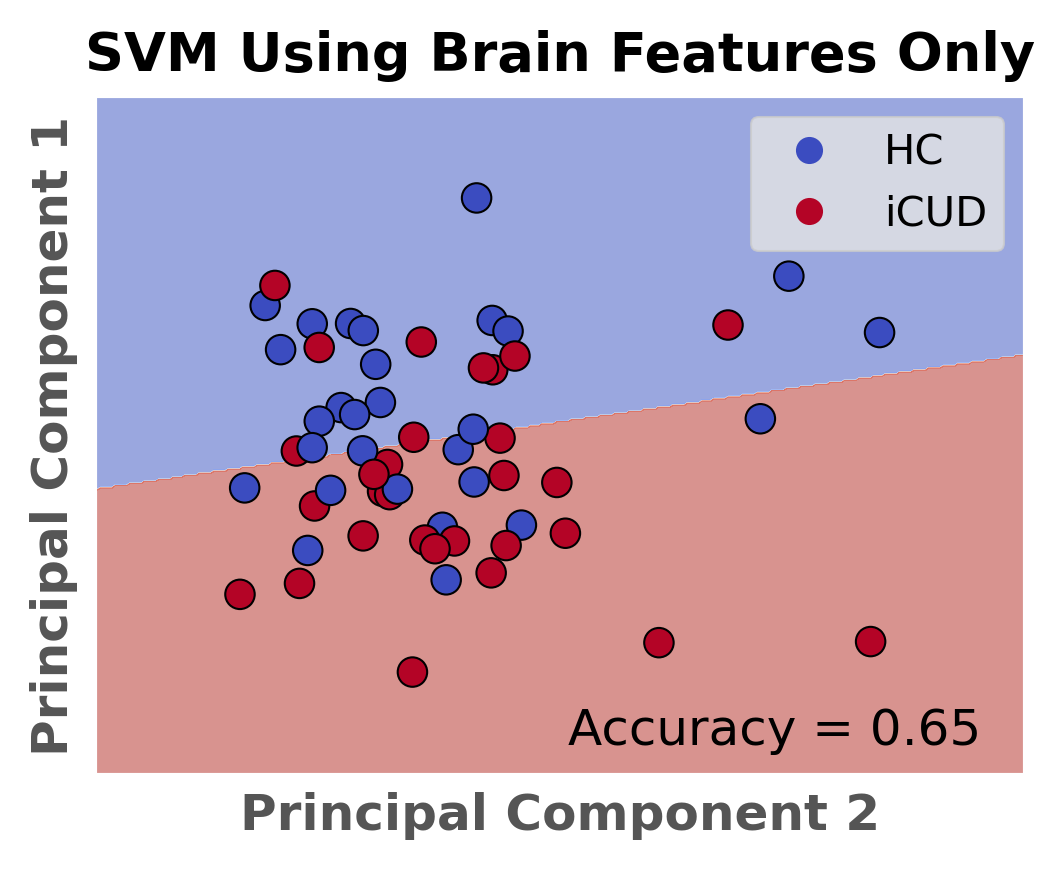

              precision    recall  f1-score   support

           0       0.50      0.58      0.54        24
           1       0.66      0.58      0.61        33

    accuracy                           0.58        57
   macro avg       0.58      0.58      0.58        57
weighted avg       0.59      0.58      0.58        57



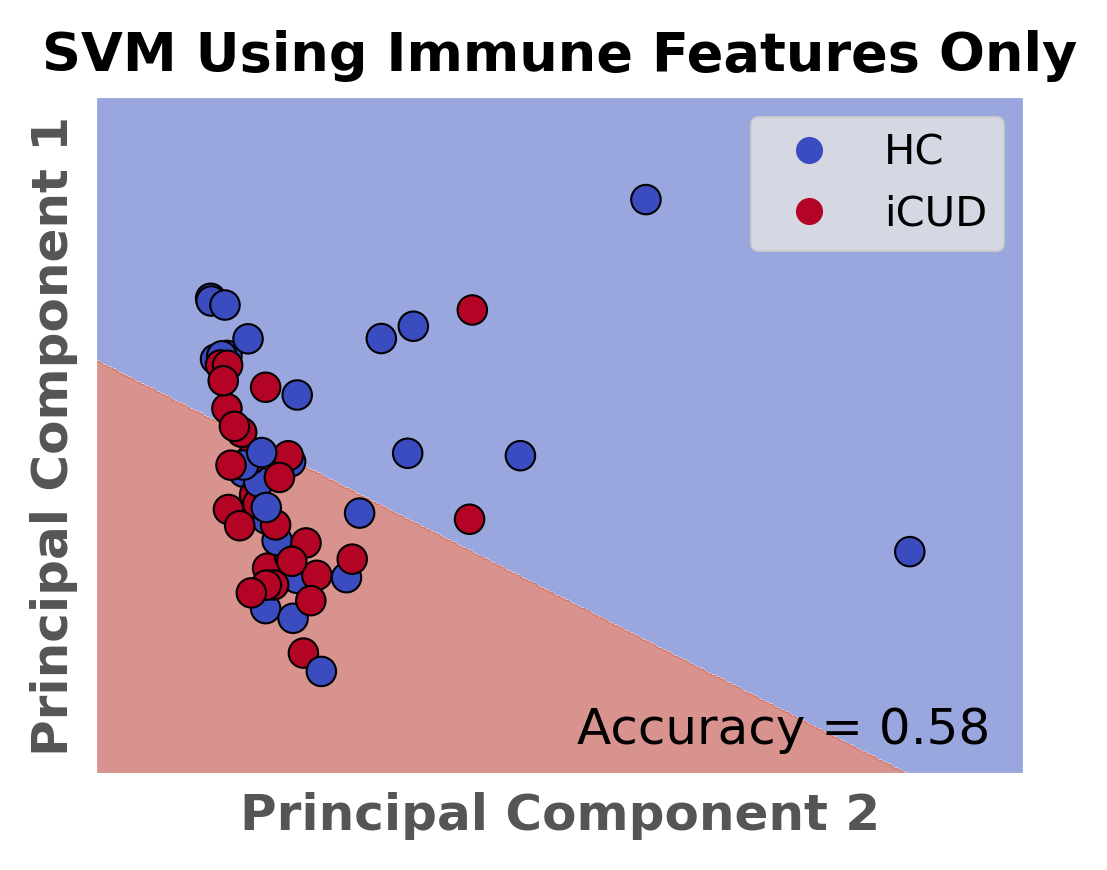

              precision    recall  f1-score   support

           0       0.64      0.69      0.67        26
           1       0.72      0.68      0.70        31

    accuracy                           0.68        57
   macro avg       0.68      0.68      0.68        57
weighted avg       0.69      0.68      0.68        57



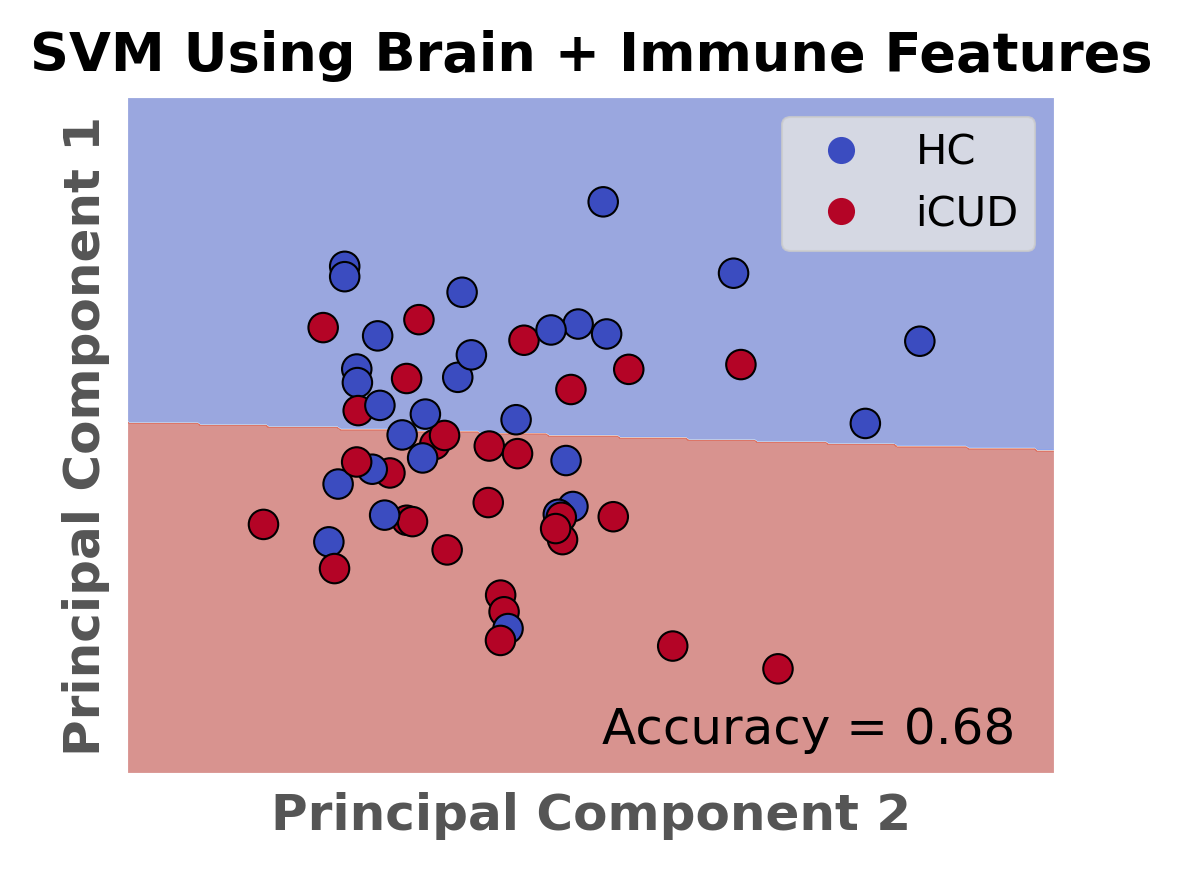

In [8]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
X_brain = mergedf.loc[:, ['Right-Putamen', 
'rh_parstriangularis_volume',   
'Right-Cerebellum-Cortex',       
'Left-Putamen',                  
'rh_lingual_volume',             
'Right-Caudate',                 
'Left-Caudate',                  
'Left-Cerebellum-Cortex',       
'rh_pericalcarine_volume',      
'Right-Amygdala' ]]
X_immune = mergedf.loc[:, ['GRO_MFI',
'PDGFABBB_MFI',
'MIP1a_MFI',
'sCD40L_MFI',
'IP10_MFI',
'VEGF_MFI',
'IL4_MFI',
'MCP1_MFI',
'MCP3_MFI',
'IL1a_MFI']]
X_combine = mergedf.loc[:, ['Right-Putamen',
'rh_parstriangularis_volume',
'PDGFABBB_MFI',
'GRO_MFI',
'Right-Cerebellum-Cortex',
'Left-Putamen',
'Left-Caudate',
'Right-Caudate',
'Left-Cerebellum-Cortex',
'lh_parahippocampal_volume']]

for X, name in zip([X_brain, X_immune, X_combine], ['Brain Features Only',
                                             'Immune Features Only',
                                             'Brain + Immune Features']):

    y = pd.get_dummies(mergedf['drug_group']).iloc[:,0]

    X_scaled = StandardScaler().fit_transform(X)
    X_pca = PCA(n_components=2, whiten=True, random_state=42).fit_transform(X_scaled)
    svc = SVC(kernel='linear')
    clf = svc.fit(X_pca, y)
    y_predict = clf.predict(X_pca)
    print(classification_report(y_predict, y))
    score = clf.score(X_pca, y)

    fig, ax = plt.subplots()
    # title for the plots
    title = ('SVM Using ' + name)
    # Set-up grid for plotting.
    X0, X1 = X_pca[:, 0], X_pca[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.5)
    scatter = ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors="k")
    classes=['HC', 'iCUD']
#     scatter = plt.scatter(x, y,c=values, cmap=colours)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    ax.text(xx.max() - .3, yy.min() + .3, ('Accuracy = %.2f' % score).lstrip('0'),
                size=12, horizontalalignment='right')
    ax.set_ylabel("{}".format("Principal Component 1"), fontweight='bold', fontsize=12)
    ax.set_xlabel("{}".format("Principal Component 2"), fontweight='bold', fontsize=12)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title, fontweight='bold', fontsize=13)
    fig.set_size_inches(4, 3, forward=True)
#     figure(dpi=700)
    plt.rcParams['figure.dpi'] = 300
    plt.show()

# significance of cv score

Evaluate the significance of a cross-validated score with permutations

Permutes targets to generate ‘randomized data’ and compute the empirical p-value against the null hypothesis that features and targets are independent.

The p-value represents the fraction of randomized data sets where the estimator performed as well or better than in the original data. A small p-value suggests that there is a real dependency between features and targets which has been used by the estimator to give good predictions. A large p-value may be due to lack of real dependency between features and targets or the estimator was not able to use the dependency to give good predictions.

In [27]:
X_brain = mergedf.iloc[:, 4:91]
X_immune = mergedf.iloc[:, 91:-5]
X_combine = mergedf.iloc[:, 4:-5]

y = pd.get_dummies(mergedf['drug_group']).iloc[:,0]

ss = StandardScaler()
svc = SVC(kernel='linear', C=0.005)
model = make_pipeline(ss, svc)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats= 10, random_state=10)

# %time score_brain, perm_scores_brain, pvalue_brain = permutation_test_score(model, X_brain, y, scoring="accuracy", cv=cv, n_permutations=1000, n_jobs=-1)
# %time score_immune, perm_scores_immune, pvalue_immune = permutation_test_score(model, X_immune, y, scoring="accuracy", cv=cv, n_permutations=1000, n_jobs=-1)
%time score_combine, perm_scores_combine, pvalue_combine = permutation_test_score(model, X_combine, y, scoring="accuracy", cv=cv, n_permutations=5000, n_jobs=-1)



CPU times: user 12.4 s, sys: 1.42 s, total: 13.8 s
Wall time: 3min 10s


<Figure size 2400x1800 with 0 Axes>

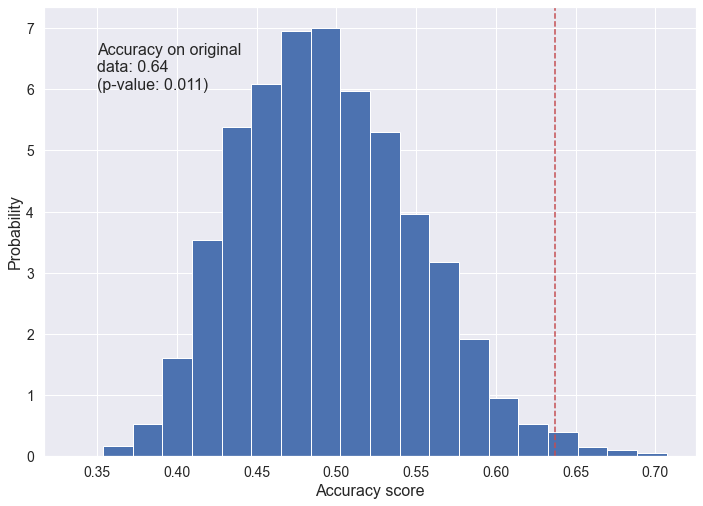

<Figure size 2400x1800 with 0 Axes>

In [28]:
fig, ax = plt.subplots()

ax.hist(perm_scores_combine, bins=20, density=True)
ax.axvline(score_combine, ls="--", color="r")
score_label = f"Accuracy on original\ndata: {score_combine:.2f}\n(p-value: {pvalue_combine:.3f})"
plt.xlabel('Accuracy score', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
ax.text(0.35, 6, score_label, fontsize=16)
figure(figsize=(4, 3), dpi=600)


In [33]:
from scipy.stats import ttest_ind
from statistics import mean, stdev
from math import sqrt
from statsmodels.stats.power import TTestIndPower

variables = ['Right-Putamen',
'rh_parstriangularis_volume',
'PDGFABBB_MFI',
'GRO_MFI',
'Right-Cerebellum-Cortex',
'Left-Putamen',
'Left-Caudate',
'Right-Caudate',
'Left-Cerebellum-Cortex',
'lh_parahippocampal_volume']

variables = ['Right-Putamen',
'rh_parstriangularis_volume',
'PDGFABBB_MFI',
'GRO_MFI',
'Right-Cerebellum-Cortex']


def cohens_d_cal(sample1, sample2):
    cohens_d = (mean(sample1) - mean(sample2)) / (sqrt((stdev(sample1) ** 2 + stdev(sample2) ** 2) / 2))
    return cohens_d

cohens_d=[]
for i in variables:
    var_cud = mergedf.where(mergedf.drug_group== 'CUD').dropna()[i]
    var_hc = mergedf.where(mergedf.drug_group== 'HC ').dropna()[i]
    print(i)
    print(ttest_ind(var_cud, var_hc))
    
    cohens_d.append(abs(cohens_d_cal(var_cud, var_hc)))
    
cohens_d    

Right-Putamen
Ttest_indResult(statistic=1.6414163433175002, pvalue=0.10641778038853951)
rh_parstriangularis_volume
Ttest_indResult(statistic=-2.8857700615404687, pvalue=0.00556798249483704)
PDGFABBB_MFI
Ttest_indResult(statistic=1.5283939729011133, pvalue=0.13214597993251492)
GRO_MFI
Ttest_indResult(statistic=1.801112264184452, pvalue=0.07716832112289115)
Right-Cerebellum-Cortex
Ttest_indResult(statistic=-1.9859573046794394, pvalue=0.052031310418674086)


[0.43351207880255754,
 0.7625418934525636,
 0.4053663590806619,
 0.4760348554881003,
 0.526231096972078]

In [34]:
mean(cohens_d)

0.5207372567591922

In [35]:
effect_size = mean(cohens_d)
alpha = 0.05
power = 0.8

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, power = power, 
                                         alpha = alpha, ratio=1, alternative='two-sided')
print(sample_size)


58.86537223406248


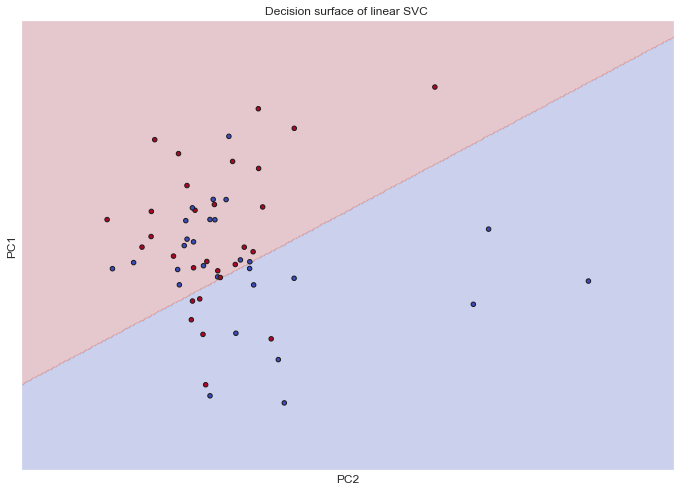

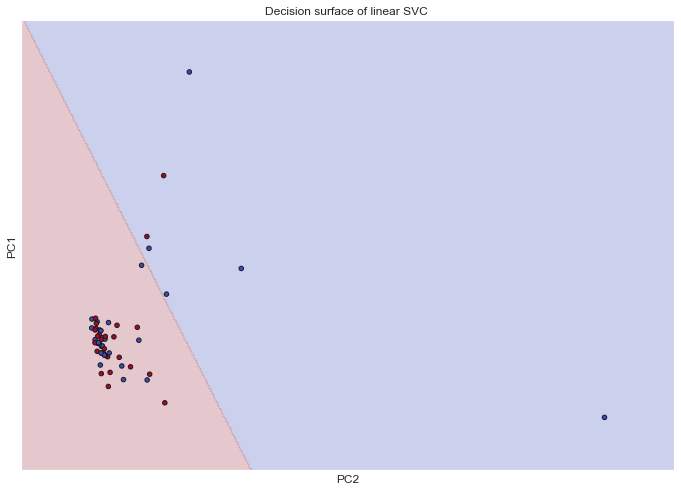

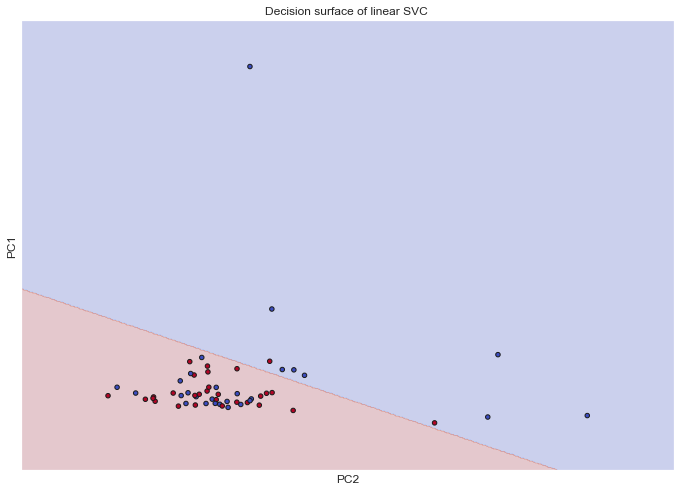

In [44]:
X_brain = mergedf.iloc[:, 4:91]
X_immune = mergedf.iloc[:, 91:-5]
X_combine = mergedf.iloc[:, 4:-5]

for X in [X_brain, X_immune, X_combine]:

    y = pd.get_dummies(mergedf['drug_group']).iloc[:,0]
 
    X_scaled = StandardScaler().fit_transform(X)
    X_pca = PCA(n_components=2, whiten=True, random_state=42).fit_transform(X_scaled)
    svc = SVC(kernel='linear')
    clf = svc.fit(X_pca, y)
    
    y_pred = clf.predict(X_pca)

    accuracy_score(y, y_pred)

    fig, ax = plt.subplots()
    title = ('Decision surface of linear SVC ')
    X0, X1 = X_pca[:, 0], X_pca[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.2)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_ylabel("{}".format("PC1"))
    ax.set_xlabel("{}".format("PC2"))
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()


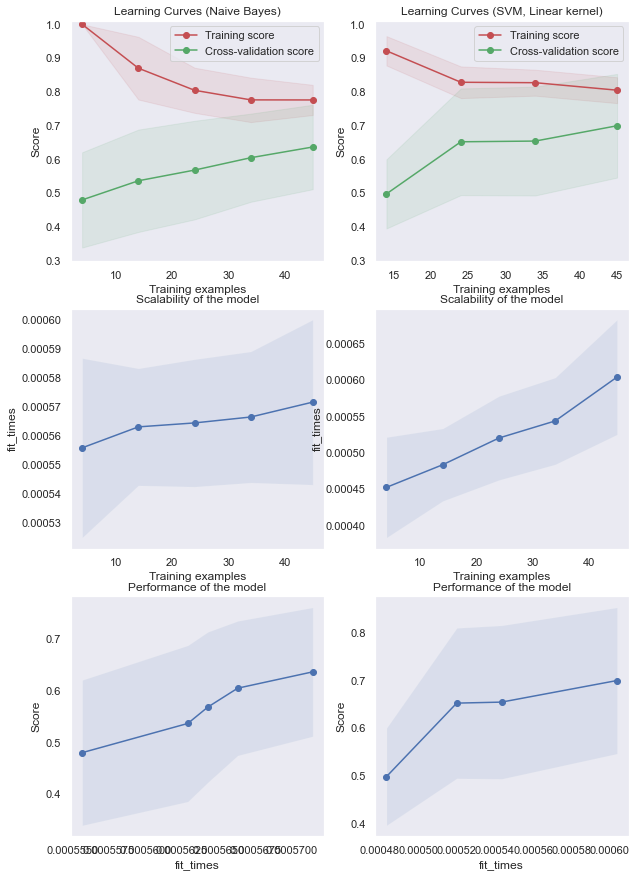

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# X, y = load_digits(return_X_y=True)
# X = mergedf.iloc[:, 4:-5]
X = mergedf.loc[:, ['Right-Putamen',
'rh_parstriangularis_volume',
'PDGFABBB_MFI',
'GRO_MFI',
'Right-Cerebellum-Cortex',
'Left-Putamen',
'Left-Caudate',
'Right-Caudate',
'Left-Cerebellum-Cortex',
'lh_parahippocampal_volume']]
X_scaled = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=0.9, whiten=True, random_state=42).fit_transform(X_scaled)

y = pd.get_dummies(mergedf['drug_group']).iloc[:,0]

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X_scaled, y, axes=axes[:, 0], ylim=(0.3, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, Linear kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats= 10, random_state=10)
estimator = SVC(kernel='linear')
plot_learning_curve(estimator, title, X_scaled, y, axes=axes[:, 1], ylim=(0.3, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

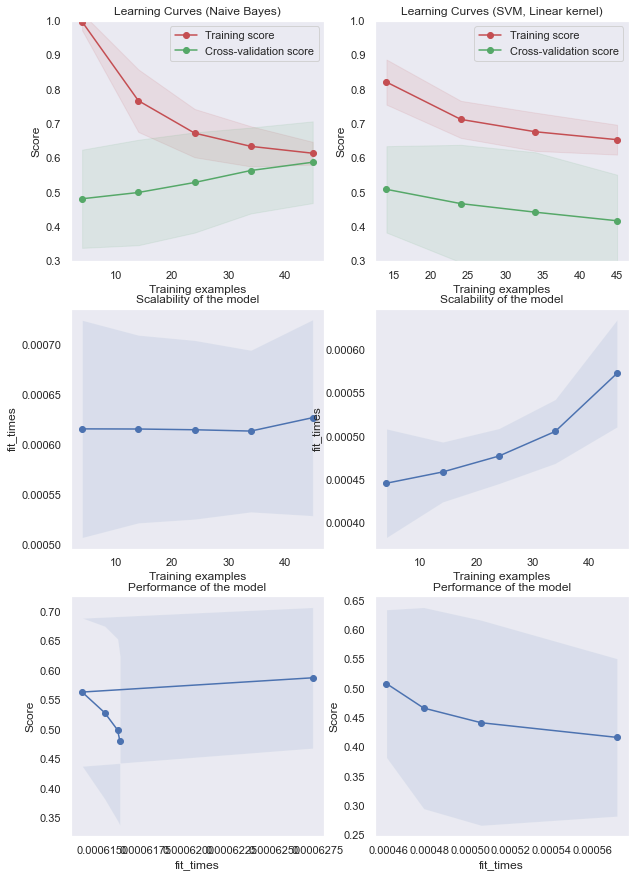

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# X, y = load_digits(return_X_y=True)
X = mergedf.iloc[:, 4:-5]
X_scaled = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=5, whiten=True, random_state=42).fit_transform(X_scaled)

y = pd.get_dummies(mergedf['drug_group']).iloc[:,0]

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X_pca, y, axes=axes[:, 0], ylim=(0.3, 1.00),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, Linear kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel='linear')
plot_learning_curve(estimator, title, X_pca, y, axes=axes[:, 1], ylim=(0.3, 1.00),
                    cv=cv, n_jobs=4)

plt.show()

#  PREDICTING DRUG GROUP WITH PCA: linear + True_Whiten + 0.9_pca   

With train_test_split(test_size=0.2):
   * Train CUD:  25
   * Train HC:  23
   * Test CUD:  7
   * Test HC:  6

In [39]:
X, y = mergedf.iloc[:, 4:-5], pd.get_dummies(mergedf['drug_group']).iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

accuracy=[]
auc=[]
precision=[]
recall=[]
model_names = []

for var in [0.70, 0.75, 0.80, 0.85, 0.90]:
    for whiten in [True, False]:
        for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
#             print("""MODEL PERFORMANCE FOR 
#             Percent variance explained == {}       
#             whiten == {} 
#             SVC kernel == {}""".format(var, whiten, kernel))

            ss = StandardScaler()
            pca = PCA(n_components=var, whiten=whiten, random_state=42)
            svc = SVC(kernel=kernel)
            model = make_pipeline(ss, pca, svc)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            accuracy.append(accuracy_score(y_test, y_pred))
            auc.append(roc_auc_score(y_test, y_pred))
            precision.append(precision_score(y_test, y_pred))
            recall.append(recall_score(y_test, y_pred))
            model_names.append('{} + {}_Whiten + {}_pca'.format(kernel, whiten, var))


eval_df = pd.DataFrame(zip(accuracy, auc, precision, recall), 
                       index=model_names)
eval_df.columns = ['Accuracy', 'AUC', 'Precision', 'Recall']
eval_df.sort_values(by = 'Accuracy', ascending = False, inplace=True)

print("\nMODEL PERFORMANCE \n")
print(eval_df)


MODEL PERFORMANCE 

                                   Accuracy       AUC  Precision    Recall
linear + True_Whiten + 0.7_pca     0.833333  0.833333   0.750000  1.000000
linear + False_Whiten + 0.75_pca   0.833333  0.833333   0.750000  1.000000
sigmoid + True_Whiten + 0.7_pca    0.833333  0.833333   0.750000  1.000000
linear + False_Whiten + 0.85_pca   0.833333  0.833333   0.750000  1.000000
sigmoid + True_Whiten + 0.85_pca   0.833333  0.833333   0.750000  1.000000
linear + True_Whiten + 0.85_pca    0.833333  0.833333   0.750000  1.000000
sigmoid + True_Whiten + 0.8_pca    0.833333  0.833333   0.750000  1.000000
linear + True_Whiten + 0.75_pca    0.833333  0.833333   0.750000  1.000000
linear + True_Whiten + 0.9_pca     0.750000  0.750000   0.666667  1.000000
rbf + True_Whiten + 0.8_pca        0.750000  0.750000   0.714286  0.833333
linear + True_Whiten + 0.8_pca     0.750000  0.750000   0.714286  0.833333
linear + False_Whiten + 0.8_pca    0.750000  0.750000   0.714286  0.833333
sigm

In [17]:
X_brain = mergedf.iloc[:, 4:91]
X_immune = mergedf.iloc[:, 91:-5]
X_combine = mergedf.iloc[:, 4:-5]

for X in [X_brain, X_immune, X_combine]:

    y = pd.get_dummies(mergedf['drug_group']).iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

    accuracy=[]
    auc=[]
    precision=[]
    recall=[]

    kernels = ['linear']
    for kernel in kernels:
        ss = StandardScaler()
        pca = PCA(n_components=2, whiten=True, random_state=42)
        svc = SVC(kernel=kernel)
        
        model = make_pipeline(ss, pca, svc)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy.append(accuracy_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))

    eval_df = pd.DataFrame(zip(accuracy, auc, precision, recall), index=kernels)
    eval_df.columns = ['Accuracy', 'AUC', 'Precision', 'Recall']

    print("\nMODEL PERFORMANCE \n")
    print(eval_df)



MODEL PERFORMANCE 

        Accuracy  AUC  Precision  Recall
linear       0.5  0.5        0.5     1.0

MODEL PERFORMANCE 

        Accuracy       AUC  Precision  Recall
linear  0.583333  0.583333   0.545455     1.0

MODEL PERFORMANCE 

        Accuracy   AUC  Precision  Recall
linear      0.75  0.75   0.666667     1.0
